In [1]:
import matplotlib

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import EarthLocation, GCRS, CartesianRepresentation, AltAz, SkyCoord, ICRS

from reproject import reproject_interp

In [4]:
from os.path import basename

In [5]:
import pandas as pd
from glob import glob
import warnings
from tqdm.autonotebook import tqdm
from shapely.geometry import LineString

<ipython-input-5-7f495fa06e00>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
warnings.simplefilter('ignore', wcs.FITSFixedWarning)

In [7]:
def read_cams_observations(fname):
    # Read file
    d = np.loadtxt(fname,
                   skiprows=3,
                   usecols=(0, 1, 2, 3,
                            4, 5, 7, 9,
                            15, 17, 19, 21,
                            23, 25, 31, 32),
                   dtype={"names": ("number", "date", "time", "tbeg",
                                    "tend", "RAinf", "DECinf", "Vinf",
                                    "LatBeg", "LonBeg", "Hbeg", "LatEnd",
                                    "LonEnd", "Hend", "Max-mV", "Int-mV"),
                          "formats": ("i4", "S10", "S11", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4")})

    # Convert time
    tstr = [f"{d.decode('UTF-8')}T{t.decode('UTF-8')}" for d, t in zip(d["date"], d["time"])]
    t = Time(tstr, format="isot", scale="utc")
    t0 = t + d["tbeg"] * u.s
    t1 = t + d["tend"] * u.s
    
    # Convert radiant and velocity
    vx = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.cos(d["RAinf"]  * u.deg) * u.km / u.s
    vy = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.sin(d["RAinf"]  * u.deg) * u.km / u.s
    vz = -d["Vinf"] * np.sin(d["DECinf"] * u.deg) * u.km / u.s

    # Convert positions
    x0, y0, z0 = EarthLocation(lat = d["LatBeg"] * u.deg,
                               lon = d["LonBeg"] * u.deg,
                               height = d["Hbeg"] * u.km).get_gcrs(obstime=t0).cartesian.xyz

    # Write out
    return Table([d["number"], t.isot, x0, y0, z0, vx, vy, vz, d["tbeg"], d["tend"]],
              names=["number", "t0", "x0", "y0", "z0", "vx", "vy", "vz", "dtmin", "dtmax"])

In [8]:
fitsfiles = sorted(glob("/data1/dijkema/A12_meteor/*.fits"))

In [9]:
fitstimes = Time([fitsfile[26:47] for fitsfile in fitsfiles], format='isot')

In [34]:
def get_fitsfiles(cams_time, extra=0, extra_before=0):
    """Get filenames of time just before CAMS time and the CAMS time itself"""
    index_with_cams_time = np.argmin(cams_time > fitstimes)
    index_with_detection = index_with_cams_time + extra # Can be tweaked, maybe -1 or +1
    index_before_detection = index_with_cams_time - 2 - extra_before # Can be tweaked, maybe -1
    assert((Time(fitsfiles[index_with_detection][26:47]) - Time(fitsfiles[index_before_detection][26:47])).to(u.s) < 16*u.s)
    return fitsfiles[index_before_detection], fitsfiles[index_with_detection]

In [11]:
# LOFAR location
loc_lofar = EarthLocation(lat = 52.9153 * u.deg,
                          lon = 6.8698 * u.deg,
                          height = 0 * u.m)

In [12]:
camsdata = pd.read_fwf("../SummaryMeteorLog CAMS Benelux 120820 .txt",
                            index_col=0,
                            header=[0, 1],
                            skip_blank_lines=True,
                            skiprows=[2],
                            skipinitialspace=True)

camsdata.columns = [
    ' '.join(col) if isinstance(col, tuple) else col
    for col in camsdata.columns
]

camsdata["astropytime_beg"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tbeg sec"]) * u.s
camsdata["astropytime_end"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tend sec"]) * u.s

camsdata = camsdata.join(pd.read_csv("aartfaac-cams-matches.csv", index_col=0))

In [13]:
cams_numbers_with_trails = camsdata[camsdata["AARTFAAC"] > 1].index

In [14]:
import ipywidgets as widgets

In [15]:
from ipywidgets import interact, interactive

In [16]:
camsdata["fitsfile_with_detection_beg"] = ""
camsdata["fitsfile_with_detection_end"] = ""
camsdata["fitsfile_before_detection"] = ""
camsdata["xbeg"] = 0
camsdata["xend"] = 0
camsdata["hbeg"] = 0 * u.km
camsdata["hend"] = 0 * u.km

In [17]:
def get_height(g, x0, x1, x):
    """
    g is trail of meteor in GCRS
    x0 is x coordinate of start in pixels
    x1 is x coordinate of end in pixels
    x is clicked coordinate in pixels
    
    Returns:
        height above WGS84 (as quantity)
    """
    xyz_beg = g.cartesian.xyz[:,0,0]
    xyz_end = g.cartesian.xyz[:,-1,0]
    xyz_interp = xyz_beg + (xyz_end-xyz_beg) * (x-x0)/(x1-x0)
    g_interp = EarthLocation(*xyz_interp)
    return g_interp.height

In [37]:
d_all = read_cams_observations("../SummaryMeteorLog CAMS Benelux 120820 .txt")

def show_figure(number, extra, extra_before):
    plt.close('all')
    # Select meteor
    c = d_all["number"] == number
    d = d_all[c]
    
    if len(d) != 1:
        print("No match for cams number", number)
        return
    
    t0 = Time(d["t0"], format="isot", scale="utc")

    try:
        fitsfile_before_detection, fitsfile_with_detection = get_fitsfiles(t0[0], extra, extra_before)
    except:
        print("No good times around", t0)
        return
    
    hdu = fits.open(fitsfile_with_detection)
    data = np.squeeze(hdu[0].data)
    header = hdu[0].header
    hdu.close()

    hdu = fits.open(fitsfile_before_detection)
    data = data - np.squeeze(hdu[0].data)
    hdu.close()

    # Construct trajectory
    dt = np.linspace(d["dtmin"], d["dtmax"], 10)
    x, y, z = d["x0"] + dt * d["vx"], d["y0"] + dt * d["vy"], d["z0"] + dt * d["vz"]
    g = GCRS(CartesianRepresentation(x=x * u.km, y=y * u.km, z=z * u.km), obstime=t0)

    # Observe from LOFAR
    obsgeoloc, obsgeovel = loc_lofar.get_gcrs_posvel(obstime=t0)
    glofar = g.transform_to(GCRS(obstime=t0, obsgeoloc=obsgeoloc, obsgeovel=obsgeovel))
    p = SkyCoord(ra=glofar.ra.degree, dec=glofar.dec.degree, unit="deg")

    # Get extrema
    pmin, pmax, pmid = p[0].squeeze(), p[-1].squeeze(), p[len(p) // 2].squeeze()

    # Rotation angle
    ang = pmin.position_angle(pmax) - 90 * u.deg
    # print(ang.to(u.deg))

    # Data WCS
    oldwcs = wcs.WCS(header, naxis=2)

    # New image size
    nx, ny = 500, 61

    # Generate new WCS
    wnew = wcs.WCS(naxis=2)
    wnew.wcs.crval = np.array([pmid.ra.degree, pmid.dec.degree])
    wnew.wcs.crpix = np.array([nx / 2, ny / 2])
    wnew.wcs.cdelt = np.array([0.1, 0.1])
    wnew.wcs.pc = np.array([[np.cos(ang), np.sin(ang)],
                            [-np.sin(ang), np.cos(ang)]])
    wnew.wcs.ctype = ["RA---STG", "DEC--STG"]    

    # Reproject meteor
    v, footprint = reproject_interp((data, oldwcs), wnew, shape_out=(ny, nx))

    vmin = np.nanmean(v) - 2 * np.nanstd(v)
    vmax = np.nanmean(v) + 4 * np.nanstd(v)

    fig, ax = plt.subplots(1, figsize=(8, 2))

    ax.imshow(v, origin="lower", interpolation="None",
              vmin=vmin, vmax=vmax)

    # Plot meteor
    x, y = p.to_pixel(wnew)

    ax.plot(x[0], y[0], "rx", alpha=0.9)
    #ax.plot(x[-1], y[-1], "ro", alpha=0.9)
    ax.plot(*(LineString(np.array([x.flatten(), y.flatten()]).T).buffer(10).exterior.xy), color="red", alpha=0.9)
#    ax.plot(x, y, "r", alpha=0.9)

    xmin, _ = pmin.to_pixel(wnew)
    ax.text(xmin, 0, camsdata.loc[number]["Hbeg km"],verticalalignment='top', horizontalalignment='center')
    
    xmax, _ = pmax.to_pixel(wnew)
    ax.text(xmax, 0, camsdata.loc[number]["Hend km"],verticalalignment='top', horizontalalignment='center')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f"#{number} ({t0[0]}), duration={camsdata.loc[number]['AARTFAAC_duration']:.0f}, type {camsdata.loc[number]['AARTFAAC']:.0f}")
    
    camsdata.loc[number, "x0"] = x[0]
    camsdata.loc[number, "x1"] = x[-1]
    
    def onclick(event):
        height = get_height(g, x[0], x[-1], event.xdata)
        if event.button == 3: # right click, end
            camsdata.loc[number, "xend"] = event.xdata
            camsdata.loc[number, "fitsfile_with_detection_end"] = basename(fitsfile_with_detection)
            camsdata.loc[number, "hend"] = (height.to(u.km)).value
        else: # single click: begin
            camsdata.loc[number, "xbeg"] = event.xdata
            camsdata.loc[number, "fitsfile_with_detection_beg"] = basename(fitsfile_with_detection)
            camsdata.loc[number, "hbeg"] = (height.to(u.km)).value
        camsdata["fitsfile_before_detection"] = basename(fitsfile_before_detection)

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    plt.show();

In [38]:
interactive_plot = interactive(show_figure, number=cams_numbers_with_trails,
                               extra=widgets.IntSlider(min=0, max=5, step=1, value=0),
                               extra_before=widgets.IntSlider(min=0, max=5, step=1, value=0))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='number', options=(50, 57, 58, 60, 65, 74, 75, 76, 77, 92, 102, 103…

In [113]:
camsdata_annotated = camsdata.loc[camsdata["hbeg"] > 0][["x0", "x1", "xbeg", "xend", "hbeg", "hend",
                                                         "fitsfile_with_detection_beg",
                                                         "fitsfile_with_detection_end", "Hbeg km", "Hend km"]]
camsdata_annotated

,x0,x1,xbeg,xend,hbeg,hend,fitsfile_with_detection_beg,fitsfile_with_detection_end,Hbeg km,Hend km
50,223.725909,270.027125,229.379022,258.411280,91.587489,83.715641,2020-08-12T21:07:28.4_16B.fits,2020-08-12T21:07:28.4_16B.fits,93.13,80.98
57,200.654579,283.896183,227.766119,282.604829,105.199097,92.100635,2020-08-12T21:12:46.5_15B.fits,2020-08-12T21:12:48.5_15B.fits,111.72,91.85
58,220.100330,270.717965,233.411280,293.088700,106.216724,92.107319,2020-08-12T21:12:46.5_15B.fits,2020-08-12T21:12:50.5_16B.fits,109.39,97.44
60,197.585397,285.573509,213.249990,285.830635,108.892115,88.601100,2020-08-12T21:14:49.3_14B.fits,2020-08-12T21:14:51.3_14B.fits,112.72,88.08
65,212.371248,277.813918,285.830635,296.314506,100.485616,97.958290,2020-08-12T21:17:48.4_16B.fits,2020-08-12T21:17:48.4_16B.fits,113.09,97.33
...,...,...,...,...,...,...,...,...,...,...
702,200.566760,291.150507,276.959668,295.508055,96.805608,91.951552,2020-08-13T03:01:37.9_16B.fits,2020-08-13T03:01:37.9_16B.fits,112.89,89.83
704,188.401979,300.631728,251.153216,357.604829,94.868386,84.543772,2020-08-13T03:02:44.3_16B.fits,2020-08-13T03:02:44.3_16B.fits,99.90,89.10
714,216.534185,275.422178,261.637087,288.249990,100.474177,90.439608,2020-08-13T03:06:35.8_16B.fits,2020-08-13T03:06:35.8_16B.fits,111.68,89.93
716,196.757305,298.184334,242.282248,284.217732,101.985730,91.261510,2020-08-13T03:07:54.3_14B.fits,2020-08-13T03:07:54.3_14B.fits,113.67,88.60


<IPython.core.display.Javascript object>


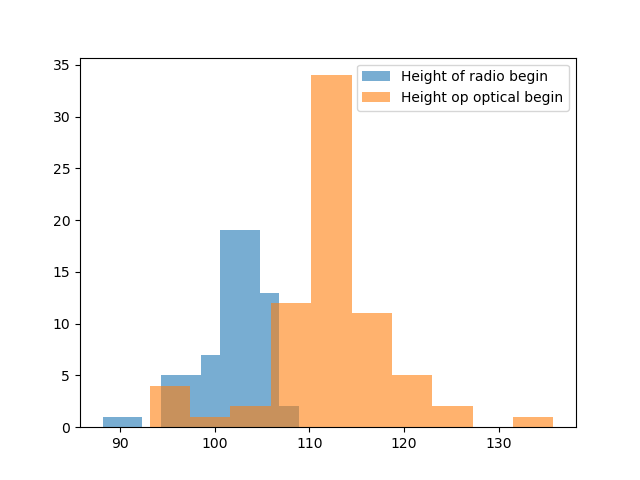

In [119]:
plt.close('all')
plt.hist(camsdata_annotated['hbeg'], alpha=0.6, label='Height of radio begin')
plt.hist(camsdata_annotated['Hbeg km'], alpha=0.6, label='Height op optical begin');
plt.legend();

<IPython.core.display.Javascript object>


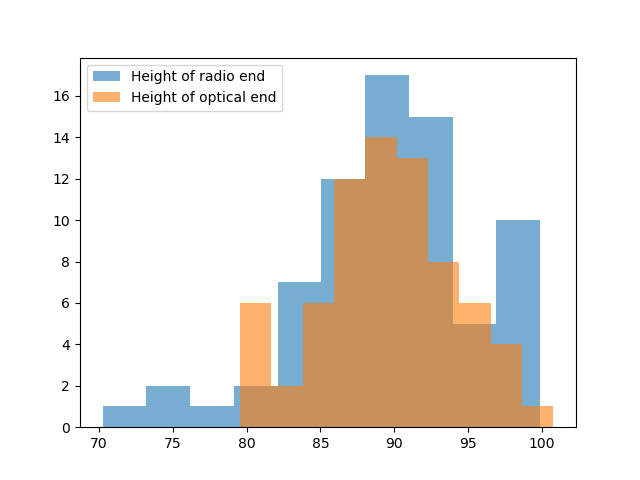

In [121]:
plt.close('all')
plt.hist(camsdata_annotated['hend'], alpha=0.6, label='Height of radio end')
plt.hist(camsdata_annotated['Hend km'], alpha=0.6, label='Height of optical end');
plt.legend();

<IPython.core.display.Javascript object>


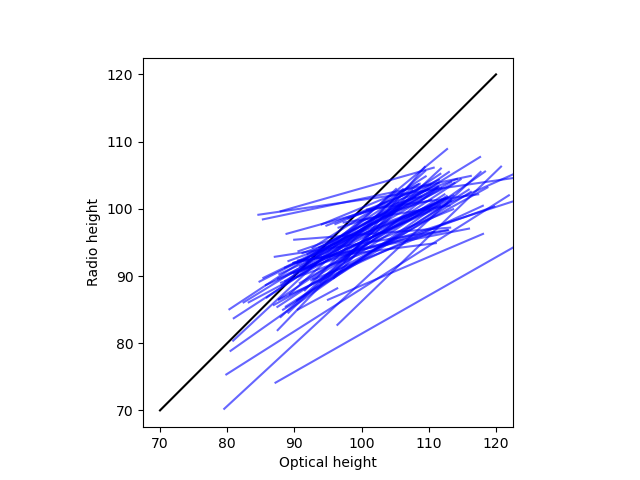

In [117]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot([70, 120], [70, 120], color='k')
for rownr, row in camsdata_annotated.iterrows():
    ax.plot([row['Hbeg km'], row['Hend km']], [row['hbeg'], row['hend']], color='blue', alpha=0.6)
ax.set_xlabel("Optical height")
ax.set_ylabel("Radio height")
ax.set_aspect("equal")
ax.set_xlim(ax.get_ylim())
plt.show()

In [118]:
camsdata_annotated.to_csv("radioheight_perseids.csv")